# Plotting policy comparison

In [15]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt


from ad_config_search.data_curation import (
    get_fn_without_ext, 
    make_data,
)

from ad_config_search.policy_utils import (
    condense_moment_policy_scores, 
    compare_policy_scores, 
    compare_policy_scores_v2,
    get_oracle_policy,
)

from ad_config_search.evaluation_utils import (
    average_config_score,
    evaluate_fine_grained_policy,
    po_past_scores,
    po_present_scores,
    gt_scores,
    average_config_score,
)

from ad_config_search.utils import (
    get_rows, 
)

from ad_config_search.config_space_control import ConfigSpace

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
num_gt_matrix = np.load("num_gt_matrix.npy")
with open("num_gt_matrix_index.pl", 'rb') as f:
    num_gt_matrix_index = pickle.load(f)

In [3]:
df_configs_5sectors = make_data(num_gt_matrix_index, num_gt_matrix, 5)

/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: divide by zero encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
100%|██████████| 255744/255744 [02:26<00:00, 1746.99it/s]


In [44]:
df_configs_1sectors = make_data(num_gt_matrix_index, num_gt_matrix, 1)

/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: divide by zero encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
100%|██████████| 255744/255744 [00:39<00:00, 6436.47it/s]


In [4]:
df_configs_5sectors

,run,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score
0,training_0004-S21-P0_5,efficientdet-d4,0.7,tail-aware,sort,0.2,1,3,50.124069
1,training_0004-S21-P1_5,efficientdet-d4,0.7,tail-aware,sort,0.2,1,3,49.791667
2,training_0004-S21-P2_5,efficientdet-d4,0.7,tail-aware,sort,0.2,1,3,6.806283
3,training_0004-S21-P3_5,efficientdet-d4,0.7,tail-aware,sort,0.2,1,3,28.217822
4,training_0004-S21-P4_5,efficientdet-d4,0.7,tail-aware,sort,0.2,1,3,32.667877
...,...,...,...,...,...,...,...,...,...
1278715,training_0003-S12-P0_5,efficientdet-d7x,0.4,tail-aware,sort,0.1,7,1,23.645320
1278716,training_0003-S12-P1_5,efficientdet-d7x,0.4,tail-aware,sort,0.1,7,1,17.297297
1278717,training_0003-S12-P2_5,efficientdet-d7x,0.4,tail-aware,sort,0.1,7,1,9.329446
1278718,training_0003-S12-P3_5,efficientdet-d7x,0.4,tail-aware,sort,0.1,7,1,6.306306


In [5]:
assert np.all(np.isfinite(df_configs_5sectors["score"]))

AssertionError: 

<AxesSubplot:xlabel='score', ylabel='Count'>

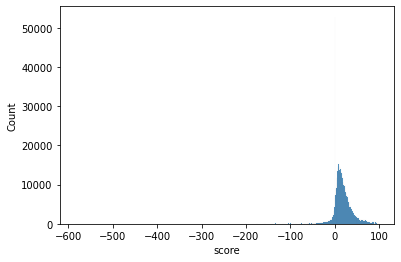

In [6]:
import seaborn as sns
sns.histplot(df_configs_5sectors["score"].replace([np.inf, -np.inf], np.nan))

ValueError: autodetected range of [-inf, 100.0] is not finite

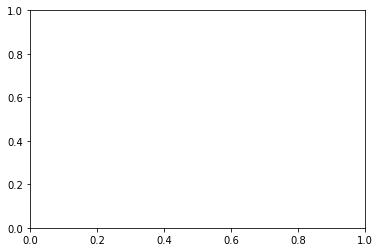

In [7]:
import seaborn as sns
sns.histplot(df_configs_5sectors["score"])

In [111]:
with open("df_configs_5sectors.pl", 'wb') as f:
    pickle.dump(df_configs_5sectors, f)

In [108]:
df_configs_1sectors = make_data(num_gt_matrix_index, num_gt_matrix, 1)

/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: divide by zero encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
100%|██████████| 255744/255744 [00:53<00:00, 4818.44it/s]


In [28]:
models_paths = list(Path("new_results/").glob("model_type=RF*"))
print(models_paths)
model_dicts = []
for p in models_paths:
    with open(p, 'rb') as f:
        model_dicts.append(pickle.load(f))
file_df = pd.DataFrame([{**m["metadata"], "index": i} for i, m in enumerate(model_dicts)])
file_df = file_df.set_index(file_df["index"]).drop(columns=["index"])
file_df

[PosixPath('new_results/model_type=RF__env_window_size=4__time_strategy=past-1-step__env_feats=pipeline-output-v1__stride_strategy=uniform_window_skip__other=k_10-condensed-space__seed=(0.43, 50)__te=-0.03.pl'), PosixPath('new_results/model_type=RF__env_window_size=4__time_strategy=present__env_feats=ground-truth-v4__stride_strategy=uniform_window_skip__other=k_10-condensed-space__seed=(0.43, 50)__te=-0.03.pl')]


,model_type,env_window_size,time_strategy,env_feats,stride_strategy,other,seed
index,,,,,,,
0,RF,4,past-1-step,pipeline-output-v1,uniform_window_skip,k_10-condensed-space,"(0.43, 50)"
1,RF,4,present,ground-truth-v4,uniform_window_skip,k_10-condensed-space,"(0.43, 50)"


(Index(['training_0000-S7-P1_5', 'training_0000-S7-P1_5',
        'training_0000-S7-P1_5', 'training_0000-S7-P1_5',
        'training_0000-S7-P1_5', 'training_0000-S7-P1_5',
        'training_0000-S7-P1_5', 'training_0000-S7-P1_5',
        'training_0000-S7-P1_5', 'training_0000-S7-P1_5',
        ...
        'training_0005-S9-P4_5', 'training_0005-S9-P4_5',
        'training_0005-S9-P4_5', 'training_0005-S9-P4_5',
        'training_0005-S9-P4_5', 'training_0005-S9-P4_5',
        'training_0005-S9-P4_5', 'training_0005-S9-P4_5',
        'training_0005-S9-P4_5', 'training_0005-S9-P4_5'],
       dtype='object', length=12815856),
 Index(['training_0000-S0-P1_5', 'training_0000-S0-P1_5',
        'training_0000-S0-P1_5', 'training_0000-S0-P1_5',
        'training_0000-S0-P1_5', 'training_0000-S0-P1_5',
        'training_0000-S0-P1_5', 'training_0000-S0-P1_5',
        'training_0000-S0-P1_5', 'training_0000-S0-P1_5',
        ...
        'training_0005-S6-P4_5', 'training_0005-S6-P4_5',
      

In [40]:
po_past = po_past_scores(model_dicts[0], num_gt_matrix, num_gt_matrix_index)
po_past_baseline = average_config_score(model_dicts[0]["train"].index, model_dicts[0]["test"].index, df_configs_5sectors, num_gt_matrix, num_gt_matrix_index)
gt_present = gt_scores(model_dicts[1], num_gt_matrix, num_gt_matrix_index)
gt_present_baseline = average_config_score(model_dicts[1]["train"].index, model_dicts[1]["test"].index, df_configs_5sectors, num_gt_matrix, num_gt_matrix_index)

contract_one_hot: 100%|██████████| 7/7 [02:11<00:00, 18.74s/it]
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    9.2s finished
po_past_scores:   4%|▍         | 2/49 [00:22<08:49, 11.26s/it]

training_0000-S1-P4_5 doesn't exist in the data fed!


  0%|          | 0/49 [00:00<?, ?it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
  2%|▏         | 1/49 [00:00<00:05,  8.16it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
  4%|▍         | 2/49 [00:00<00:05,  8.62it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
  6%|▌         | 3/49 [00:00<00:05,  8.54it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered

only found [1, 2, 3, 4] of scenario training_0000-S0
only found [1, 2, 3, 4] of scenario training_0000-S1
only found [1, 2, 3, 4] of scenario training_0000-S10


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
  8%|▊         | 4/49 [00:00<00:04, 10.52it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len


only found [1, 2, 3, 4] of scenario training_0000-S11
only found [1, 2, 3, 4] of scenario training_0000-S12
only found [1, 2, 3, 4] of scenario training_0000-S13


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 12%|█▏        | 6/49 [00:00<00:04, 10.51it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 16%|█▋        | 8/49 [00:00<00:03, 10.51it/s]

only found [1, 2, 3, 4] of scenario training_0000-S14
only found [1, 2, 3, 4] of scenario training_0000-S15
only found [1, 2, 3, 4] of scenario training_0000-S16


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 20%|██        | 10/49 [00:00<00:03, 10.49it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len


only found [1, 2, 3, 4] of scenario training_0000-S17
only found [1, 2, 3, 4] of scenario training_0000-S18
only found [1, 2, 3, 4] of scenario training_0000-S19


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 24%|██▍       | 12/49 [00:01<00:03, 10.39it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 29%|██▊       | 14/49 [00:01<00:03, 10.38it/s]

only found [1, 2, 3, 4] of scenario training_0000-S2
only found [1, 2, 3, 4] of scenario training_0000-S20
only found [1, 2, 3, 4] of scenario training_0000-S21


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 33%|███▎      | 16/49 [00:01<00:03, 10.08it/s]

only found [1, 2, 3, 4] of scenario training_0000-S22
only found [1, 2, 3, 4] of scenario training_0000-S23


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 37%|███▋      | 18/49 [00:01<00:03,  9.96it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len


only found [1, 2, 3, 4] of scenario training_0000-S3
only found [1, 2, 3, 4] of scenario training_0000-S4
only found [1, 2, 3, 4] of scenario training_0000-S5


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 41%|████      | 20/49 [00:01<00:02, 10.20it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len


only found [1, 2, 3, 4] of scenario training_0000-S6
only found [1, 2, 3, 4] of scenario training_0002-S24


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 45%|████▍     | 22/49 [00:02<00:02,  9.92it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 49%|████▉     | 24/49 [00:02<00:02, 10.19it/s]

only found [1, 2, 3, 4] of scenario training_0002-S4
only found [1, 2, 3, 4] of scenario training_0002-S6
only found [1, 2, 3, 4] of scenario training_0002-S9


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 53%|█████▎    | 26/49 [00:02<00:02, 10.30it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len


only found [1, 2, 3, 4] of scenario training_0003-S1
only found [1, 2, 3, 4] of scenario training_0003-S11
only found [1, 2, 3, 4] of scenario training_0003-S14


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 57%|█████▋    | 28/49 [00:02<00:02, 10.33it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 61%|██████    | 30/49 [00:02<00:01, 10.30it/s]

only found [1, 2, 3, 4] of scenario training_0003-S16
only found [1, 2, 3, 4] of scenario training_0003-S18
only found [1, 2, 3, 4] of scenario training_0003-S20


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 65%|██████▌   | 32/49 [00:03<00:01, 10.25it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len


only found [1, 2, 3, 4] of scenario training_0003-S22
only found [1, 2, 3, 4] of scenario training_0003-S24
only found [1, 2, 3, 4] of scenario training_0003-S5


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 69%|██████▉   | 34/49 [00:03<00:01,  9.94it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 73%|███████▎  | 36/49 [00:03<00:01, 10.19it/s]

only found [1, 2, 3, 4] of scenario training_0003-S7
only found [1, 2, 3, 4] of scenario training_0003-S9
only found [1, 2, 3, 4] of scenario training_0004-S1


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 78%|███████▊  | 38/49 [00:03<00:01, 10.32it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len


only found [1, 2, 3, 4] of scenario training_0004-S12
only found [1, 2, 3, 4] of scenario training_0004-S14
only found [1, 2, 3, 4] of scenario training_0004-S16


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 82%|████████▏ | 40/49 [00:03<00:00, 10.34it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 86%|████████▌ | 42/49 [00:04<00:00, 10.34it/s]

only found [1, 2, 3, 4] of scenario training_0004-S19
only found [1, 2, 3, 4] of scenario training_0004-S20
only found [1, 2, 3, 4] of scenario training_0004-S22


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 90%|████████▉ | 44/49 [00:04<00:00, 10.44it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len


only found [1, 2, 3, 4] of scenario training_0004-S5
only found [1, 2, 3, 4] of scenario training_0005-S0
only found [1, 2, 3, 4] of scenario training_0005-S12


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 94%|█████████▍| 46/49 [00:04<00:00, 10.37it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
 98%|█████████▊| 48/49 [00:04<00:00, 10.33it/s]

only found [1, 2, 3, 4] of scenario training_0005-S19
only found [1, 2, 3, 4] of scenario training_0005-S23
only found [1, 2, 3, 4] of scenario training_0005-S6


/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
100%|██████████| 49/49 [00:04<00:00, 10.29it/s]
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 400 out of 400 | elapsed:    1.2s finished
contract_one_hot:  20%|██        | 1/5 [00:00<00:00,  9.27it/s]

training_0000-S0-P0_5


  0%|          | 0/49 [00:00<?, ?it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
  2%|▏         | 1/49 [00:00<00:05,  9.21it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
  6%|▌         | 3/49 [00:00<00:04,  9.76it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cu

In [41]:
oracle_5sectors_policy = get_oracle_policy(df_configs_5sectors)
oracle_5sectors_policy_scores = evaluate_fine_grained_policy(oracle_5sectors_policy, num_gt_matrix, num_gt_matrix_index)

  0%|          | 0/148 [00:00<?, ?it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
  1%|▏         | 2/148 [00:00<00:14, 10.26it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
  3%|▎

In [45]:
oracle_1sectors_policy = get_oracle_policy(df_configs_1sectors)
oracle_1sectors_policy_scores = evaluate_fine_grained_policy(oracle_1sectors_policy, num_gt_matrix, num_gt_matrix_index)

  0%|          | 0/148 [00:00<?, ?it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
/data/ges/AD-config-search/python-libraries/ad_config

In [17]:
all_scenarios = list(oracle_5sectors_policy_scores.keys())
import random
random.shuffle(all_scenarios)
fake_test = all_scenarios[:len(all_scenarios)//3]
fake_train = all_scenarios[len(all_scenarios)//3:]
num_chunks = 5
fake_test_fine = [s+f"-P{i}_{num_chunks}" for i in range(num_chunks) for s in fake_test]
fake_train_fine = [s+f"-P{i}_{num_chunks}" for i in range(num_chunks) for s in fake_train]
avg_scores = average_config_score(fake_train_fine, fake_test_fine, df_configs_5sectors, num_gt_matrix, num_gt_matrix_index)

  0%|          | 0/49 [00:00<?, ?it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
  2%|▏         | 1/49 [00:00<00:06,  7.70it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
  4%|▍         | 2/49 [00:00<00:05,  8.27it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  mota_arr = 1 - cum_num / (cum_gt)  # n x num_sectors x sector_len
  6%|▌         | 3/49 [00:00<00:05,  8.36it/s]/data/ges/AD-config-search/python-libraries/ad_config_search/ad_config_search/evaluation_utils.py:29: RuntimeWarning: invalid value encountered

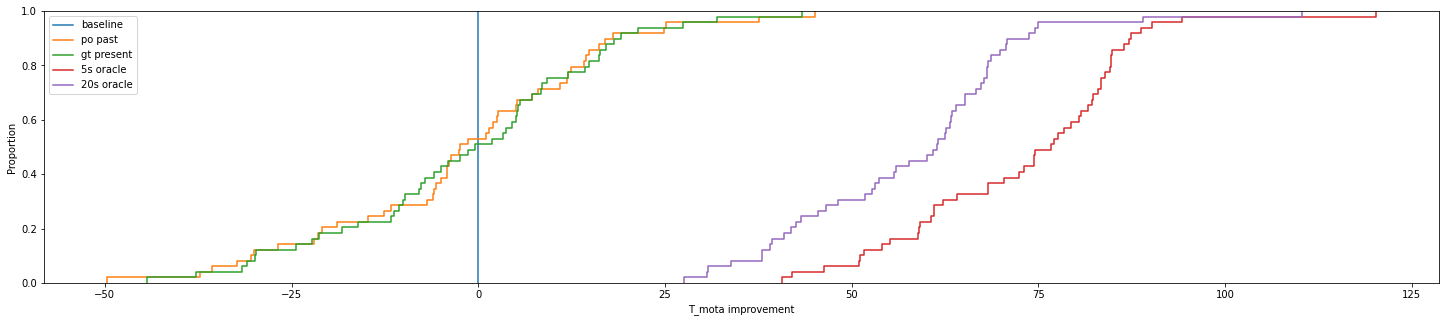

In [46]:
plt.figure(figsize=(25,5))

to_plot = [
    (avg_scores, avg_scores, "baseline"),
    (po_past_baseline, po_past, "po past"),
    (gt_present_baseline, gt_present, "gt present"),
    (avg_scores, {k: v for k, v in oracle_5sectors_policy_scores.items() if k in avg_scores.keys()}, "5s oracle"),
    (avg_scores, {k: v for k, v in oracle_1sectors_policy_scores.items() if k in avg_scores.keys()}, "20s oracle")
]
compare_policy_scores_v2(to_plot, "T_mota")

In [23]:
{k: v for k, v in oracle_5sectors_policy.items() if k in avg_scores.keys()}.keys()

dict_keys([])